# Working with morphologies (or `jaxley.io`)

In this tutorial, you will learn how to:

- Load morphologies and make them compatible with `Jaxley`  
- Use the visualization features  
- Assemble a small network of morphologically accurate cells.  
- How to use `Jaxley`s graph pipeline, which offers interoperability with `networkX`. We will:
    - define morphologies via `networkX` graphs.
    - export morphologies to `networkX` graphs.
    - import morphologies using `Jaxley`'s graph pipeline.

Here are two code snippets which you will learn to understand in this tutorial:


```python
import jaxley as jx

cell = jx.read_swc("my_cell.swc", ncomp=4)
cell.branch(2).set_ncomp(2)  # Modify the number of compartments of a branch.
```

---
```python
import jaxley as jx
import networkx as nx
from jaxley.io.graph import swc_to_graph, make_jaxley_compatible, from_graph, to_graph

graph = swc_to_graph("tests/swc_files/morph.swc")
graph = make_jaxley_compatible(graph)
cell = from_graph(graph)

graph = to_graph(cell)

pos = {k: np.array([d["x"], d["y"]]) for k, d in graph.nodes(data=True)}
nx.draw(graph, pos, node_size=5)
```

To work with more complicated morphologies, `Jaxley` supports importing morphological reconstructions via `.swc` files.
`.swc` is currently the only supported format. Other formats like `.asc` need to be converted to `.swc` first, for example using the BlueBrain's [morph-tool](https://github.com/BlueBrain/morph-tool). For more information on the exact specifications of `.swc` see [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html).

In [9]:
import jaxley as jx
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse

from jaxley.io.graph import swc_to_graph, make_jaxley_compatible, from_graph, to_graph

To work with `.swc` files, `Jaxley` implements a custom `.swc` reader. The reader traces the morphology and identifies all uninterrupted sections. These uninterrupted sections are called `branches` in `Jaxley`. Each `branch` is then further partitioned into `compartments`.

To demonstrate this, let's import an example morphology of a Layer 5 pyramidal cell and visualize it.

In [2]:
# import swc file into jx.Cell object
fname = "data/morph.swc"
cell = jx.read_swc(fname, ncomp=8)  # Use eight compartments per branch.

# print shape (num_branches, num_comps)
print(cell.shape)

cell.show()

(157, 1256)


,local_comp_index,global_comp_index,local_branch_index,global_branch_index,local_cell_index,global_cell_index
0,0,0,0,0,0,0
1,1,1,0,0,0,0
2,2,2,0,0,0,0
3,3,3,0,0,0,0
4,4,4,0,0,0,0
...,...,...,...,...,...,...
1251,3,1251,156,156,0,0
1252,4,1252,156,156,0,0
1253,5,1253,156,156,0,0
1254,6,1254,156,156,0,0


As we can see, this yields a morphology that is approximated by 1256 compartments. Depending on the amount of detail that you need, you can also change the number of compartments in each branch:

In [3]:
cell = jx.read_swc(fname, ncomp=2)

# print shape (num_branches, num_comps)
print(cell.shape)

cell.show()

(157, 314)


,local_comp_index,global_comp_index,local_branch_index,global_branch_index,local_cell_index,global_cell_index
0,0,0,0,0,0,0
1,1,1,0,0,0,0
2,0,2,1,1,0,0
3,1,3,1,1,0,0
4,0,4,2,2,0,0
...,...,...,...,...,...,...
309,1,309,154,154,0,0
310,0,310,155,155,0,0
311,1,311,155,155,0,0
312,0,312,156,156,0,0


The above assigns the same number of compartments to every branch. To use a different number of compartments in individual branches, you can use `.set_ncomp()`:

In [4]:
cell.branch(1).set_ncomp(4)

As you can see below, branch `0` has two compartments (because this is what was passed to `jx.read_swc(..., ncomp=2)`), but branch `1` has four compartments:

In [5]:
cell.branch([0, 1]).nodes

,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,global_cell_index,global_branch_index,global_comp_index,controlled_by_param
0,0,0,0,0.050000,8.119000,5000.0,1.0,-70.0,0,0,0,0
1,0,0,1,0.050000,8.119000,5000.0,1.0,-70.0,0,0,1,0
2,0,1,0,3.120779,7.806172,5000.0,1.0,-70.0,0,1,2,1
3,0,1,1,3.120779,7.111231,5000.0,1.0,-70.0,0,1,3,1
4,0,1,2,3.120779,5.652394,5000.0,1.0,-70.0,0,1,4,1
5,0,1,3,3.120779,3.869247,5000.0,1.0,-70.0,0,1,5,1


Once imported the compartmentalized morphology can be viewed using `vis`.  

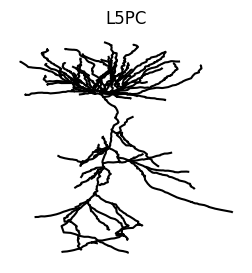

In [6]:
# visualize the cell
cell.vis()
plt.axis("off")
plt.title("L5PC")
plt.show()

`vis` can be called on any `jx.Module` and every `View` of the module. This means we can also for example use `vis` to highlight each branch. This can be done by iterating over each branch index and calling `cell.branch(i).vis()`. Within the loop.

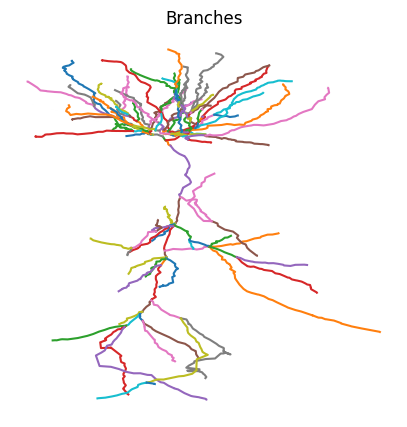

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# define colorwheel with 10 colors
colors = plt.cm.tab10.colors
for i, branch in enumerate(cell.branches):
    branch.vis(ax=ax, color=colors[i % 10])
plt.axis("off")
plt.title("Branches")
plt.show()

While we only use two compartments to approximate each branch in this example, we can see the morphology is still plotted in great detail. This is because we always plot the full `.swc` reconstruction irrespective of the number of compartments used. The morphology lives seperately in the `cell.xyzr` attribute in a per branch fashion. 

In addition to plotting the full morphology of the cell using points `vis(type="scatter")` or lines `vis(type="line")`, `Jaxley` also supports plotting a detailed morphological `vis(type="morph")` or approximate compartmental reconstruction `vis(type="comp")` that correctly considers the thickness of the neurite. Note that `"comp"` plots the lengths of each compartment which is equal to the length of the traced neurite. While neurites can be zigzaggy, the compartments that approximate them are straight lines. This can lead to miss-aligment of the compartment ends. For details see the documentation of `vis`. 

The morphologies can either be projected onto 2D or also rendered in 3D. 

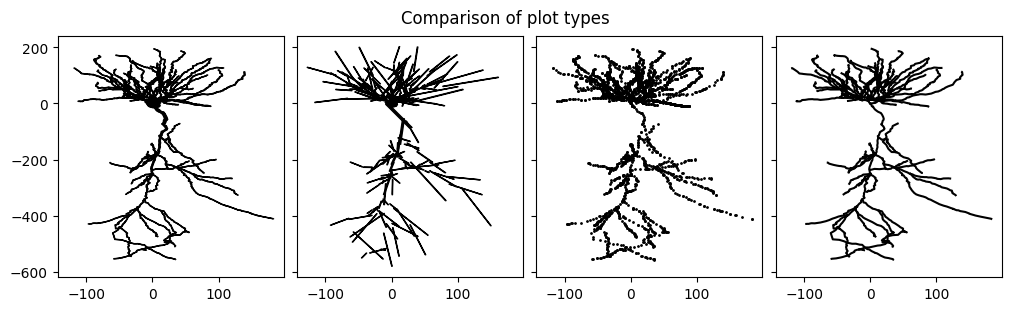

In [10]:
# visualize the cell
fig, ax = plt.subplots(1, 4, figsize=(10, 3), layout="constrained", sharex=True, sharey=True)
cell.vis(ax=ax[0], type="morph", dims=[0,1])
cell.vis(ax=ax[1], type="comp", dims=[0,1])
cell.vis(ax=ax[2], type="scatter", dims=[0,1], s=1)
cell.vis(ax=ax[3], type="line", dims=[0,1])
fig.suptitle("Comparison of plot types")
plt.show()

In [11]:
# set to interactive mode
# %matplotlib notebook

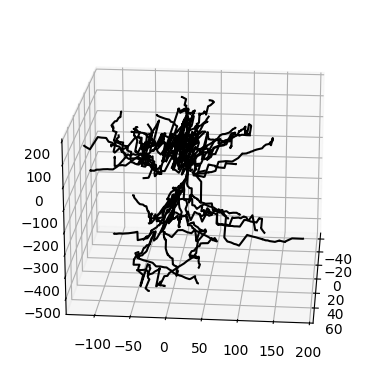

In [12]:
# plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cell.vis(ax=ax, type="line", dims=[2,0,1])
ax.view_init(elev=20, azim=5)
plt.show()

Since `Jaxley` supports grouping different branches or compartments together, we can also use the `id` labels provided by the `.swc` file to assign group labels to the `jx.Cell` object.

['soma', 'basal', 'apical', 'custom']


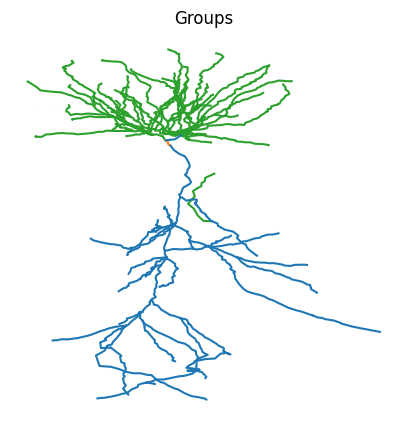

In [13]:
print(list(cell.groups.keys()))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
colors = plt.cm.tab10.colors
cell.basal.vis(ax=ax, color=colors[2])
cell.soma.vis(ax=ax, color=colors[1])
cell.apical.vis(ax=ax, color=colors[0])
plt.axis("off")
plt.title("Groups")
plt.show()

To build a network of morphologically detailed cells, we can now connect several reconstructed cells together and also visualize the network. However, since all cells are going to have the same center, `Jaxley` will naively plot all of them on top of each other. To seperate out the cells, we therefore have to move them to a new location first.

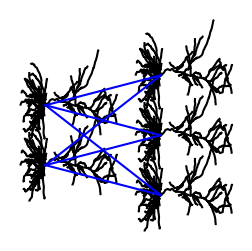

In [14]:
net = jx.Network([cell]*5)
jx.connect(net[0,0,0], net[2,0,0], IonotropicSynapse())
jx.connect(net[0,0,0], net[3,0,0], IonotropicSynapse())
jx.connect(net[0,0,0], net[4,0,0], IonotropicSynapse())

jx.connect(net[1,0,0], net[2,0,0], IonotropicSynapse())
jx.connect(net[1,0,0], net[3,0,0], IonotropicSynapse())
jx.connect(net[1,0,0], net[4,0,0], IonotropicSynapse())

net.rotate(-90)

net.cell(0).move(0, 300)
net.cell(1).move(0, 500)

net.cell(2).move(900, 200)
net.cell(3).move(900, 400)
net.cell(4).move(900, 600)

net.vis()
plt.axis("off")
plt.show()

Congrats! You have now learned how to vizualize and build networks out of very complex morphologies. To simulate this network, you can follow the steps in the tutorial on [how to build a network](https://jaxley.readthedocs.io/en/latest/tutorials/02_small_network.html) or continue to learn about how you can interface with `networkX`.

## Working with graphs

While `swc` is a great way to save, load and specify complex morphologies, often more flexibility is needed. In these cases graphs present a natural way to represent and work with neural morphologies, allowing for easy fixing, pruning, smoothing and traversal of neural morphologies on the fly. For this purpose `Jaxley` also comes with a seperate `networkX` toolset, that allows for easy interoperability between `networkX` graphs and `Jaxley` Modules.

To demonstrate this, let's first define a simple morphology via a networkX graph.

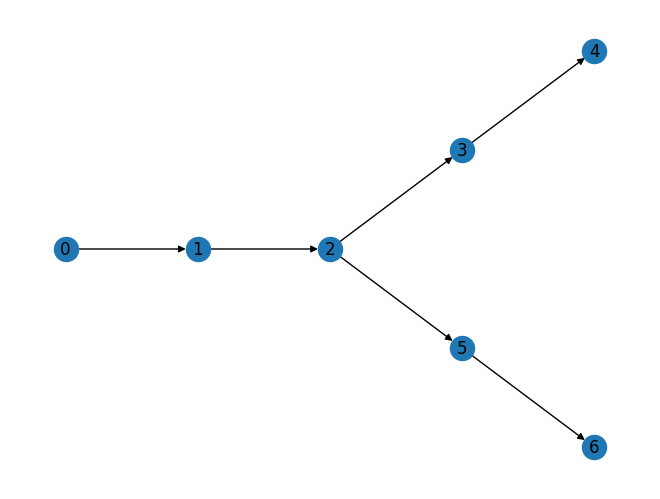

In [2]:
nodes = {
    0: {"id":1, "x": -1, "y": 0, "z": 0, "r": 2.0},
    1: {"id":1, "x": 0, "y": 0, "z": 0, "r": 2.0},
    2: {"id":1, "x": 1, "y": 0, "z": 0, "r": 2.0},
    3: {"id":1, "x": 2, "y": 1, "z": 0, "r": 1.0},
    4: {"id":1, "x": 3, "y": 2, "z": 0, "r": 1.0},
    5: {"id":1, "x": 2, "y": -1, "z": 0, "r": 1.0},
    6: {"id":1, "x": 3, "y": -2, "z": 0, "r": 1.0},
} 
edges = ((0, 1),(1, 2),(2, 3),(3, 4),(2, 5),(5, 6))

g = nx.DiGraph()
g.add_nodes_from(nodes.items())
g.add_edges_from(edges, l=1)

# Setting any of these attributes is optional. It is sufficient to define the 
# connectivity and simply do g = nx.DiGraph(edges). In this case, r and l will 
# be set to default values and x, y, z can be computed using Cell.compute_xyz().

nx.draw(g, pos={k: (v["x"], v["y"]) for k, v in nodes.items()}, with_labels=True)

The above graph can now be treated like a traced morphological reconsruction. This means we can use `io.graph` to import it into a `jx.Module` using the `from_graph` method.

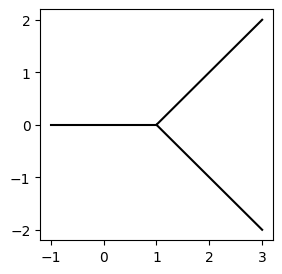

In [5]:
cell = from_graph(g, ncomp=2)

cell.vis()
plt.show()

To work with more complex morphologies `io.graph` also provides a way to import `swc` reconstructions as graphs. This means we can easily view the entire tracing of the morphology. At this stage the `networkX` graph could also easily be fixed, pruned or smoothed. To demo this lets remove the apical dendrites (id=4).

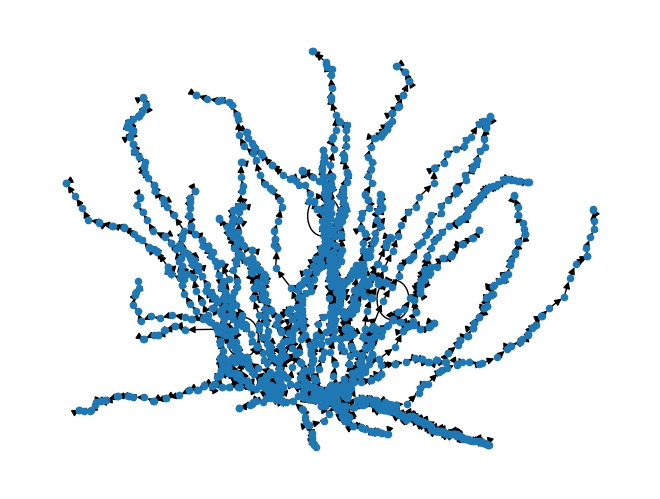

In [39]:
fname = "data/morph.swc"
graph = swc_to_graph(fname)

# manipulate the graph
ids = nx.get_node_attributes(graph, "id")
ids = {k: v for k, v in ids.items() if v != 4}
graph = nx.subgraph(graph, ids).copy()

pos = {k: (v["x"], v["y"]) for k, v in graph.nodes.items()}
nx.draw(graph, pos=pos, node_size=20)

To make the traced and possibly edited morphology compatible with `Jaxley` we now need to segment it into branches and then divide the branches up into compartments. This can be done via `io.graph.make_jaxley_compatible`, which produces a subgraph of the original morphology and adds additional attributes that `Jaxley` requires to simulate it. For details see the documentation of `make_jaxley_compatible`.

node attributes {'x': 0.0, 'y': 0.0, 'z': 0.0, 'l': 0.012500000186264515, 'branch_index': 0, 'comp_index': 0, 'group': ['soma'], 'radius': 8.119000434875488, 'length': 0.025, 'cell_index': 0}
edge attributes {'l': 0.001, 'type': 'intra_branch'}


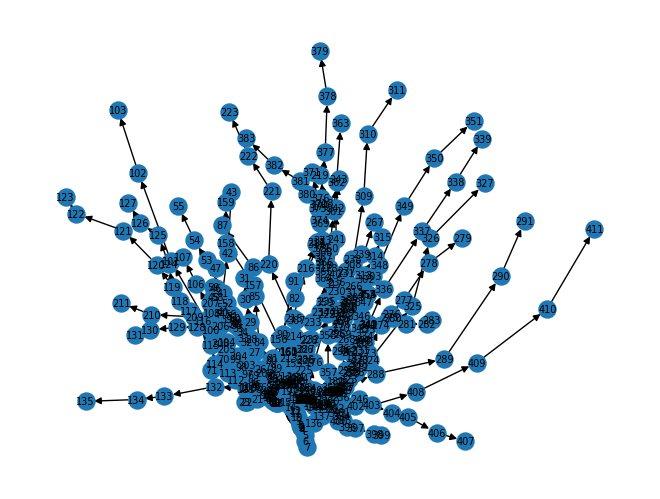

In [40]:
graph = make_jaxley_compatible(graph)

print(f"node attributes {graph.nodes[0]}")
print(f"edge attributes {graph.edges[(0, 1)]}")

pos = {k: (v["x"], v["y"]) for k, v in graph.nodes.items()}
nx.draw(graph, pos=pos, with_labels=True, font_size=7, node_size=150)

Again we can use the `from_graph` function to convert the graph into a `Cell` object, which `Jaxley` can then simulate or optimize. 

In [68]:
cell = from_graph(graph, ncomp=2)

# add mechanism to cell
cell.insert(HH())

# change parameters, pretending the cell has been optimized
for branch in cell:
    y_pos = branch.xyzr[0][0,1]
    branch.set("HH_gNa", 0.5 + 0.5 * y_pos)

To close the loop `Jaxley` also offers the option to export any `Module` to a `networkX` graph object. This ability offers another way to store or share the current Module state, since `to_graph` attaches all relevant attributes to the nodes and eges of the graph. It can also be used to make more complex visualizations, using any of these attributes i.e. channel densities very easily.

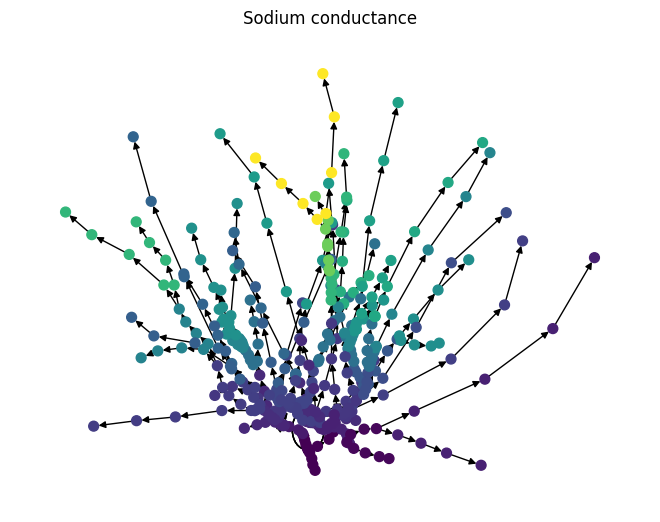

In [69]:
graph = to_graph(cell)

# plot of the cell, coloring each node according to the sodium conductance
pos = {k: (v["x"], v["y"]) for k, v in graph.nodes.items()}
nx.draw(graph, pos=pos, node_color=[graph.nodes[n]["HH_gNa"] for n in graph.nodes], cmap="viridis", with_labels=False, node_size=50)
plt.title("Sodium conductance")
plt.show()

Congrats! You have now learned how to interface with networkX to further customize and manipulate imported morphologies.